In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [15]:
gdf = gpd.read_file("../data_processed/reaches_model.gpkg", layer="reaches_model")

In [16]:
gdf.head()

,Permanent_,FDate,Resolution,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FlowDir,WBArea_Per,FType,...,reach_area_stats_sum,reach_area_stats_mean,reach_area_stats_median,reach_area_stats_stddev,reach_area_stats_minority,reach_area_stats_majority,reach_area_stats_q1,reach_area_stats_q3,reach_area_stats_iqr,geometry
0,60585024,2015-11-27,2,NaN,NaN,1.508,16020102000634,1,NaN,460,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,"LINESTRING (-12424267.142 4979471.92, -1242422..."
1,60585024,2015-11-27,2,NaN,NaN,1.508,16020102000634,1,NaN,460,...,0.004753,0.000475,0.000000,0.000652,0.000786,0.0,0.000000,0.000887,0.000887,"LINESTRING (-12424090.771 4979640.61, -1242408..."
2,60585024,2015-11-27,2,NaN,NaN,1.508,16020102000634,1,NaN,460,...,0.049711,0.004519,0.002138,0.007525,0.002138,0.0,0.000000,0.002793,0.002793,"LINESTRING (-12423862.735 4979726.432, -124238..."
3,60585024,2015-11-27,2,NaN,NaN,1.508,16020102000634,1,NaN,460,...,0.019826,0.001983,0.002184,0.001151,0.001673,0.0,0.001673,0.002548,0.000875,"LINESTRING (-12423618.875 4979777.705, -124235..."
4,60585024,2015-11-27,2,NaN,NaN,1.508,16020102000634,1,NaN,460,...,0.007039,0.000640,0.000000,0.001492,0.002066,0.0,0.000000,0.000000,0.000000,"LINESTRING (-12423374.668 4979813.127, -124233..."


In [17]:
# Check available columns
print(gdf.columns.tolist())

['Permanent_', 'FDate', 'Resolution', 'GNIS_ID', 'GNIS_Name', 'LengthKM', 'ReachCode', 'FlowDir', 'WBArea_Per', 'FType', 'FType_Text', 'FCode', 'FCode_Text', 'Enabled', 'InUtah', 'IsMajor', 'Submerged', 'reach_id', 'slope_fid', 'slope_count', 'slope_unique', 'slope_min', 'slope_max', 'slope_range', 'slope_sum', 'slope_mean', 'slope_median', 'slope_stddev', 'slope_minority', 'slope_majority', 'slope_q1', 'slope_q3', 'slope_iqr', 'elev_fid', 'elev_count', 'elev_unique', 'elev_min', 'elev_max', 'elev_range', 'elev_sum', 'elev_mean', 'elev_median', 'elev_stddev', 'elev_minority', 'elev_majority', 'elev_q1', 'elev_q3', 'elev_iqr', 'reach_area_stats_fid', 'reach_area_stats_count', 'reach_area_stats_unique', 'reach_area_stats_min', 'reach_area_stats_max', 'reach_area_stats_range', 'reach_area_stats_sum', 'reach_area_stats_mean', 'reach_area_stats_median', 'reach_area_stats_stddev', 'reach_area_stats_minority', 'reach_area_stats_majority', 'reach_area_stats_q1', 'reach_area_stats_q3', 'reach_a

In [18]:
#pick actual field names
SLOPE = "slope_mean"
ELEV  = "elev_mean"
AREA  = "reach_area_stats_max"

In [19]:
# basic cleaning
gdf = gdf.dropna(subset=[SLOPE, ELEV, AREA]).copy()
gdf = gdf[gdf[AREA] > 0].copy()

In [20]:
# log transform the drainange area
gdf["log_area"] = np.log(gdf[AREA])

In [21]:
def minmax(s):
    return (s - s.min()) / (s.max() - s.min())

In [22]:
#normalize
gdf["slope_norm"] = minmax(gdf[SLOPE])
gdf["elev_norm"]  = minmax(gdf[ELEV])
gdf["area_norm"]  = minmax(gdf["log_area"])

In [23]:
# Habitat suitability index (HSI)
# Weights: elevation (proxy for temperature) slightly higher
gdf["hsi"] = 0.4 * gdf["elev_norm"] + 0.3 * gdf["slope_norm"] + 0.3 * gdf["area_norm"]

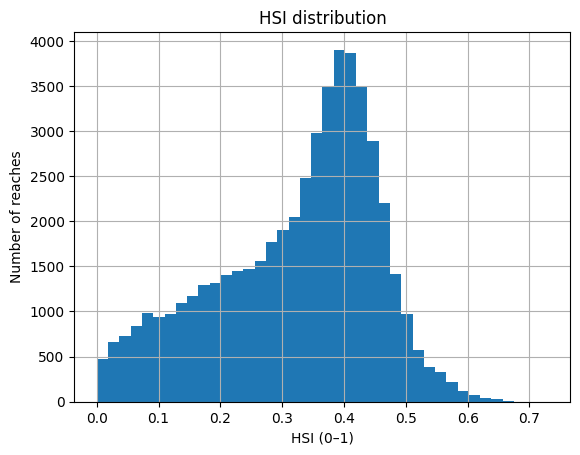

In [24]:
# initial distribution of HSI
plt.figure()
gdf["hsi"].hist(bins=40)
plt.xlabel("HSI (0–1)")
plt.ylabel("Number of reaches")
plt.title("HSI distribution")
plt.show()

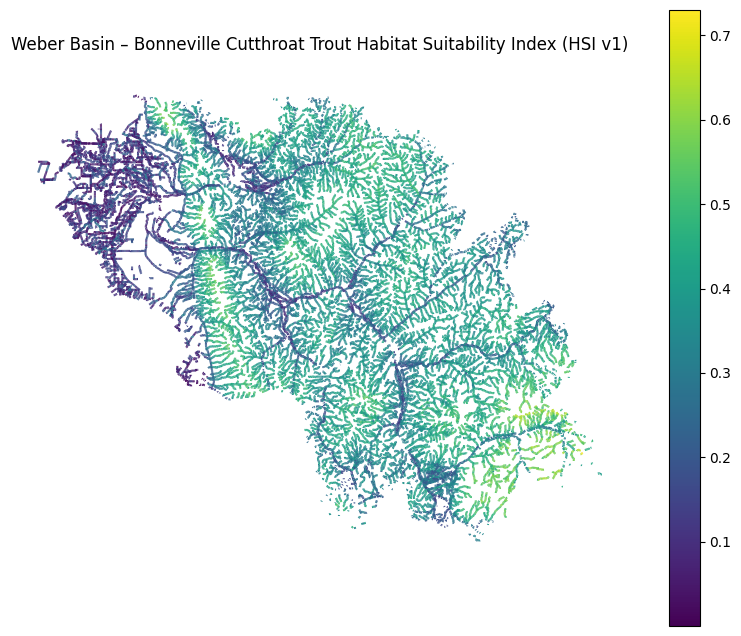

In [26]:
# mapplt.figure()
ax = gdf.plot(column="hsi", legend=True, figsize=(10, 8))
ax.set_axis_off()
ax.set_title("Weber Basin – Bonneville Cutthroat Trout Habitat Suitability Index (HSI v1)")
plt.show()


In [ ]:
#Save geospatial layer with HSI values
gdf.to_file("outputs/reaches_hsi.gpkg", layer="reaches_hsi", driver="GPKG")

# Save non-spatial table for review
gdf.drop(columns="geometry").to_csv("outputs/reaches_hsi_table.csv", index=False)

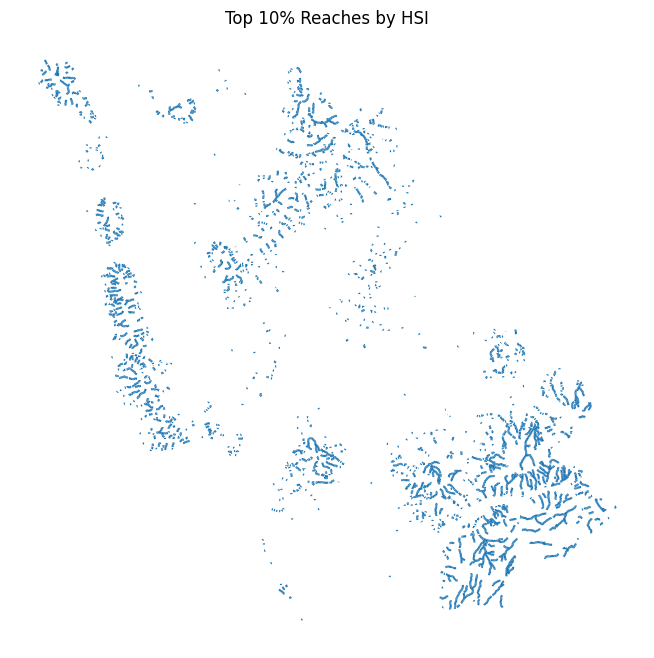

In [ ]:
import os

# Top habitat reaches
threshold = gdf["hsi"].quantile(0.90)
top = gdf[gdf["hsi"] >= threshold].copy()

# Ensure the outputs directory exists
os.makedirs("outputs", exist_ok=True)

top.to_file("outputs/reaches_hsi_top10pct.gpkg", layer="top10pct", driver="GPKG")

ax = top.plot(figsize=(10, 8))
ax.set_axis_off()
ax.set_title("Top 10% Reaches by HSI")
plt.show()